In [1]:
import skimage as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import nd2
import napari

from scipy import ndimage as ndi
from scipy import stats

In [2]:
# Function of extract nuc mask
def nucmask(im):
    iso = sk.filters.threshold_li(im)
    a = np.where(im>iso, 1, 0)

    # Fill holes in the binary image
    b = ndi.binary_fill_holes(a)

    # Create a square structuring element
    ero_selem = sk.morphology.square(5)
    # Perform binary erosion
    c = sk.morphology.erosion(b, ero_selem)

    # remove the small pieces
    d = sk.measure.label(c)
    e = sk.morphology.remove_small_objects(d, min_size=900)

    l = sk.measure.label(e)
    return l

(3, 3960, 2640)


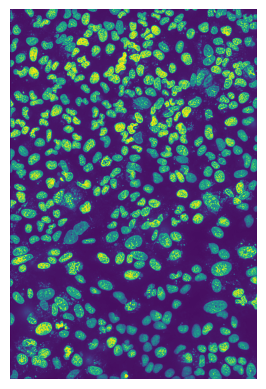

In [19]:
file_path = "/Users/wangnongyun/Movies/DATA/20240305 ActRep CEBPB/Act_14_003.nd2"
im = nd2.imread(file_path)
print(im.shape)
plt.imshow(im[2,:,:])
plt.axis('off')
plt.show()

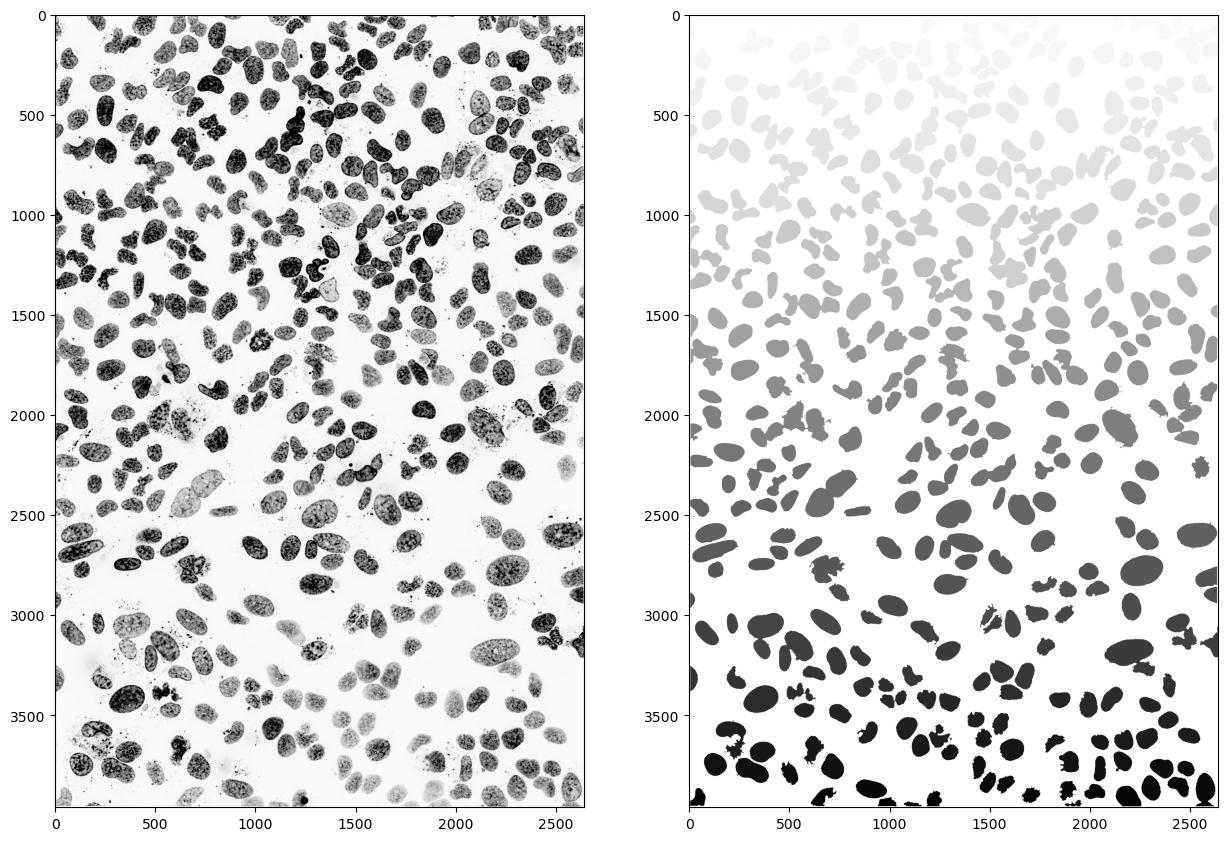

In [3]:
# check the mask
file_path = "/Users/wangnongyun/Movies/DATA/20240305 ActRep CEBPB/Act_14_003.nd2"
im = nd2.imread(file_path)

DAPI = im[2,:,:]
maskDAPI = nucmask(DAPI)

# plot the mask
fig,(ax2,ax3) = plt.subplots(1,2, figsize=(15,15))
ax2.imshow(DAPI,cmap="Greys")
ax3.imshow(maskDAPI,cmap="Greys")


In [16]:
GFP_mean_intensities = []
CY5_mean_intensities = []

# Assuming 'maskDAPI' is your DAPI mask or the relevant channel you want to threshold
# And 'im' contains your intensity images for GFP and CY5

# Calculate the threshold using the Li method
CY5_im = im[1,:,:]
threshold_value = sk.filters.threshold_li(CY5_im)

# Apply threshold to create a binary mask of high-intensity regions
high_intensity_mask = maskDAPI > threshold_value

# Iterate through each labeled region in your original mask
for region in sk.measure.regionprops(maskDAPI):
    coords = region.coords
    
    # Check if this region has any high-intensity areas as per the Li threshold
    if np.any(high_intensity_mask[coords[:, 0], coords[:, 1]]):
        # Proceed to extract and process GFP and CY5 intensities only if the region passes the threshold check
        
        GFP = im[0,:,:]
        CY5 = im[1,:,:]

        GFP_intensity_values = GFP[coords[:, 0], coords[:, 1]]
        CY5_intensity_values = CY5[coords[:, 0], coords[:, 1]]
        
        # Calculate the mean intensity for this region
        GFP_mean_intensity = np.mean(GFP_intensity_values)
        CY5_mean_intensity = np.mean(CY5_intensity_values)

        # Append the mean intensity to our lists
        GFP_mean_intensities.append(GFP_mean_intensity)
        CY5_mean_intensities.append(CY5_mean_intensity)

lap_gfp = GFP_mean_intensities  
lap_cy5 = CY5_mean_intensities


In [5]:
# act-vp16 and # act-syn
file_VP16 = "/Users/wangnongyun/Movies/DATA/20240305 ActRep CEBPB/Act_VP16_003.nd2"
file_syn = "/Users/wangnongyun/Movies/DATA/20240305 ActRep CEBPB/Act_RUNX2syn_003.nd2"

im_VP16 = nd2.imread(file_VP16)
im_syn = nd2.imread(file_syn)

DAPI_VP16 = im_VP16[2,:,:]
DAPI_syn = im_syn[2,:,:]
mask_VP16 = nucmask(DAPI_VP16)
mask_syn = nucmask(DAPI_syn)

# Initialize a list to hold mean intensity values for each nucleus
VP16_GFP_mean_intensities = []
VP16_CY5_mean_intensities = []
syn_GFP_mean_intensities = []
syn_CY5_mean_intensities = []

# Iterate through each labeled region
for region in sk.measure.regionprops(mask_VP16):
    # Extract the coordinates of this region from the nucmask
    coords = region.coords
    
    # Extract the intensity values for these coordinates from the intensity image
    GFP = im[0,:,:]
    CY5 = im[1,:,:]
    GFP_intensity_values = GFP[coords[:, 0], coords[:, 1]]
    CY5_intensity_values = CY5[coords[:, 0], coords[:, 1]]
    
    # Calculate the mean intensity for this region
    GFP_mean_intensity = np.mean(GFP_intensity_values)
    CY5_mean_intensity = np.mean(CY5_intensity_values)

    # Append the mean intensity to our list
    VP16_GFP_mean_intensities.append(GFP_mean_intensity)
    VP16_CY5_mean_intensities.append(CY5_mean_intensity)

for region in sk.measure.regionprops(mask_syn):
    # Extract the coordinates of this region from the nucmask
    coords = region.coords
    
    # Extract the intensity values for these coordinates from the intensity image
    GFP = im[0,:,:]
    CY5 = im[1,:,:]
    GFP_intensity_values = GFP[coords[:, 0], coords[:, 1]]
    CY5_intensity_values = CY5[coords[:, 0], coords[:, 1]]
    
    # Calculate the mean intensity for this region
    GFP_mean_intensity = np.mean(GFP_intensity_values)
    CY5_mean_intensity = np.mean(CY5_intensity_values)

    # Append the mean intensity to our list
    syn_GFP_mean_intensities.append(GFP_mean_intensity)
    syn_CY5_mean_intensities.append(CY5_mean_intensity)


In [ ]:
# Example data with varying sizes
lap_gfp = GFP_mean_intensities
lap_cy5 = CY5_mean_intensities
vp16_cy5 = VP16_CY5_mean_intensities
syn_gfp = syn_GFP_mean_intensities
syn_cy5 = syn_CY5_mean_intensities
#####
data = []

# Populate the data list with observations
samples = ['Lap', 'VP16', 'Syn']
for sample in samples:
    for dye, values in zip(['GFP', 'CY5'], [eval(f'{sample.lower()}_gfp'), eval(f'{sample.lower()}_cy5')]):
        for value in values:
            data.append({'Sample': sample, 'Dye': dye, 'Intensity': value})

# Convert to DataFrame
df = pd.DataFrame(data)

######
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a grouped box plot
g = sns.catplot(x="Sample", y="Intensity", hue="Dye", data=df, kind="box", height=5, aspect=1.5, palette="Set2", dodge=True)

# Add swarmplot to show individual data points
sns.swarmplot(x="Sample", y="Intensity", hue="Dye", data=df, color="k", alpha=0.8, dodge=True, ax=g.ax)

# Improve the legend
handles, labels = g.ax.get_legend_handles_labels()
g.ax.legend(handles[:2], labels[:2], title="Dye")

plt.title("Intensity Distribution by Sample and Dye")
plt.show()


In [6]:
# Example data with varying sizes - ensure these variables are defined in your workspace
lap_gfp = GFP_mean_intensities
lap_cy5 = CY5_mean_intensities
vp16_gfp = VP16_GFP_mean_intensities
vp16_cy5 = VP16_CY5_mean_intensities
syn_gfp = syn_GFP_mean_intensities
syn_cy5 = syn_CY5_mean_intensities

data = []

# Assuming 'samples' and 'dyes' are correctly defined
samples = ['Lap', 'VP16', 'Syn']
dyes = ['GFP', 'CY5']

# Dynamically check if the data exists before trying to access it
for sample in samples:
    for dye in dyes:
        variable_name = f"{sample.lower()}_{dye.lower()}"
        
        # Check if the variable name exists in the local scope
        if variable_name in locals():
            values = locals()[variable_name]
            for value in values:
                data.append({'Sample': sample, 'Dye': dye, 'Intensity': value})

# Continue with DataFrame creation and plotting as before
df = pd.DataFrame(data)

# Plotting code remains the same...


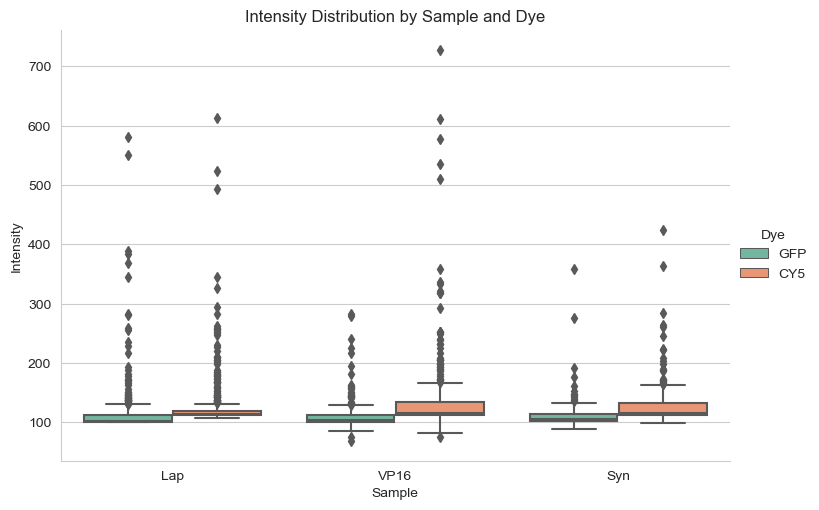

In [7]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a grouped box plot
g = sns.catplot(x="Sample", y="Intensity", hue="Dye", data=df, kind="box", height=5, aspect=1.5, palette="Set2", dodge=True)

# Add swarmplot to show individual data points
# sns.swarmplot(x="Sample", y="Intensity", hue="Dye", data=df, color="k", alpha=0.8, dodge=True, ax=g.ax)

# Improve the legend
handles, labels = g.ax.get_legend_handles_labels()
# g.ax.legend(handles[:2], labels[:2], title="Dye")

plt.title("Intensity Distribution by Sample and Dye")
plt.show()

In [ ]:
# Combine all GFP data into a DataFrame for statistical testing
df_gfp = pd.DataFrame({
    'Lap': lap_gfp,
    'VP16': vp16_gfp,
    'Syn': syn_gfp
})

# Conduct ANOVA
f_value, p_value = stats.f_oneway(df_gfp['Lap'].dropna(), df_gfp['VP16'].dropna(), df_gfp['Syn'].dropna())
print("ANOVA p-value:", p_value)

# Prepare data for plotting
data_plot = pd.DataFrame({
    'Sample': ['Lap'] * len(lap_gfp) + ['Syn'] * len(syn_gfp),
    'Intensity': np.concatenate([lap_gfp, syn_gfp]),
    'Dye': ['GFP'] * (len(lap_gfp) + len(syn_gfp))
})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sample', y='Intensity', hue='Dye', data=data_plot, palette="Set2")
sns.swarmplot(x='Sample', y='Intensity', data=data_plot, color='k', alpha=0.8)

plt.title("GFP Intensity Distribution by Sample")
plt.show()

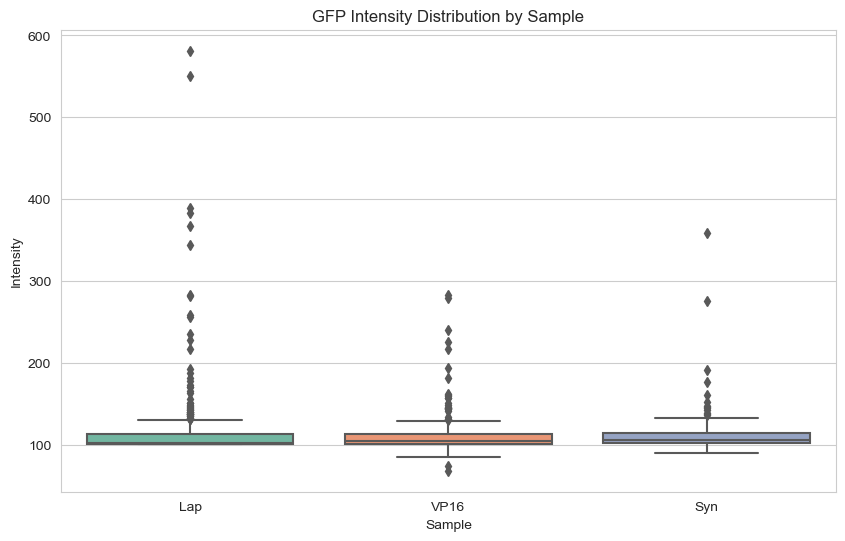

In [9]:
# Assuming you have GFP intensity lists for different samples:
lap_gfp = GFP_mean_intensities  # Your GFP data for Lap sample
vp16_gfp = VP16_GFP_mean_intensities
syn_gfp = syn_GFP_mean_intensities  # Your GFP data for Syn sample
# Note: VP16 data is omitted based on your scenario

# Prepare the data
data = []
for intensity in lap_gfp:
    data.append({'Sample': 'Lap', 'Intensity': intensity, 'Dye': 'GFP'})
for intensity in vp16_gfp:
    data.append({'Sample': 'VP16', 'Intensity': intensity, 'Dye': 'GFP'})
for intensity in syn_gfp:
    data.append({'Sample': 'Syn', 'Intensity': intensity, 'Dye': 'GFP'})

# Now create a DataFrame from the list of dictionaries
df_gfp = pd.DataFrame(data)

# This DataFrame is now properly structured for plotting and analysis, with no requirement for equal-length lists.

# Assuming df_gfp is the DataFrame prepared above
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sample', y='Intensity', data=df_gfp, palette="Set2")
#sns.swarmplot(x='Sample', y='Intensity', data=df_gfp, color='k', alpha=0.8)

# Add your statistical comparison here (e.g., marking significant differences)

plt.title("GFP Intensity Distribution by Sample")
plt.show()
